c:\Users\dango\OneDrive - UWE Bristol\projects\thesis-project\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries imported successfully.
Project Base Directory: c:\Users\dango\OneDrive - UWE Bristol\projects\thesis-project
Trained Model Path: c:\Users\dango\OneDrive - UWE Bristol\projects\thesis-project\models\base_strata_aug_Xception-class_weights.pth
Processed Training Data Path: c:\Users\dango\OneDrive - UWE Bristol\projects\thesis-project\data\processed\Xception\train_dataset.pt
XAI Output Directory: c:\Users\dango\OneDrive - UWE Bristol\projects\thesis-project\results\xai_output


c:\Users\dango\OneDrive - UWE Bristol\projects\thesis-project\venv\lib\site-packages\timm\models\_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Xception model architecture created successfully.
Successfully loaded trained model weights from: c:\Users\dango\OneDrive - UWE Bristol\projects\thesis-project\models\base_strata_aug_Xception-class_weights.pth
Successfully loaded and preprocessed sample image: c:\Users\dango\OneDrive - UWE Bristol\projects\thesis-project\user_inputs\user_sample1.jpg


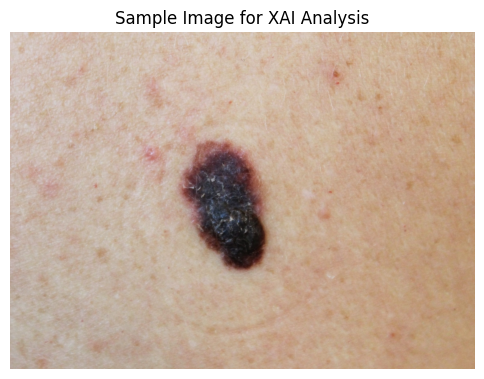


Model Prediction: Class 'Benign' (Index: 0) with confidence 51.54%

--- Generating Grad-CAM ---


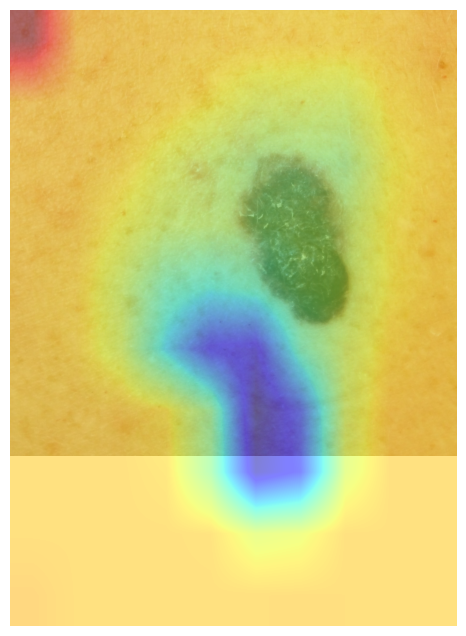

Grad-CAM image saved to: c:\Users\dango\OneDrive - UWE Bristol\projects\thesis-project\results\xai_output\user_sample1_xai_gradcam.png

--- Generating SHAP (Occlusion-based) ---


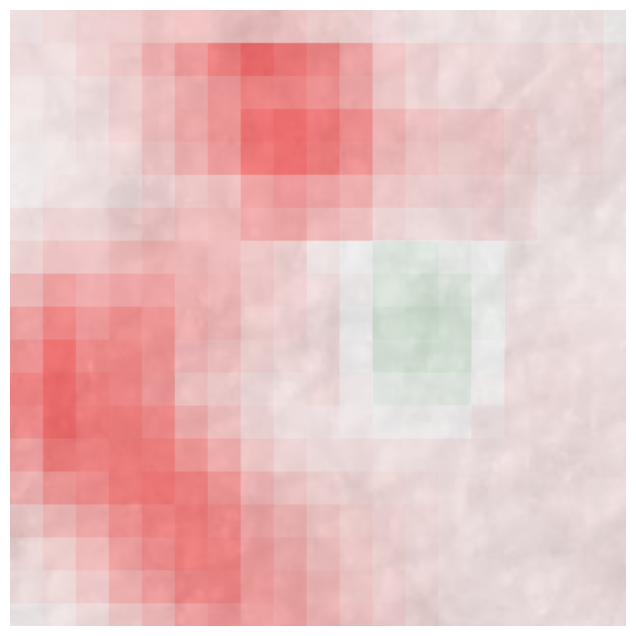

SHAP (Occlusion) image saved to: c:\Users\dango\OneDrive - UWE Bristol\projects\thesis-project\results\xai_output\user_sample1_xai_shap.png

--- Generating Influence Functions (Simulated Report as CSV) ---
Generated 25 simulated influence scores.
Simulated Influence Function CSV report saved to: c:\Users\dango\OneDrive - UWE Bristol\projects\thesis-project\results\xai_output\user_sample1_influence_function.csv


--- XAI Pipeline Execution Complete ---
All results have been generated and saved to the 'results/xai_output' directory.


In [1]:
# # XAI Pipeline for Skin Cancer Classification (Integrated Version)
#
# This notebook loads the trained Xception model, applies various XAI methods (Grad-CAM, SHAP, Influence Functions),
# and exports the results in a format ready for the LLM integration pipeline.
#
# Author: Berkay Yildirim
# Branch: feature/TP-31/xai-methods

# --- 1. Setup and Initialization ---
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import timm
import os
import sys
from captum.attr import LayerGradCam, Occlusion
from captum.attr import visualization as viz
import random

# Local imports
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils.common import get_test_transforms

print("Libraries imported successfully.")

# --- 2. Define Project Structure and File Paths ---

CWD = os.getcwd()
if os.path.basename(CWD) == 'notebooks':
    BASE_DIR = os.path.abspath(os.path.join(CWD, os.pardir))
else:
    BASE_DIR = CWD

# --- UPDATED PATHS ---
MODEL_PATH = os.path.join(BASE_DIR, 'models', 'base_strata_aug_Xception-class_weights.pth')
SAMPLE_IMAGE_PATH = os.path.join(BASE_DIR, 'user_inputs', 'user_sample1.jpg')
METADATA_PATH = os.path.join(BASE_DIR, 'data', 'metadata_updated.csv')
# Path to the processed training data tensors from notebook 02
PROCESSED_TRAIN_DATA_PATH = os.path.join(BASE_DIR, 'data', 'processed', 'Xception', 'train_dataset.pt')
# The outputs are saved to the top-level 'results' folder
OUTPUT_DIR = os.path.join(BASE_DIR, 'results', 'xai_output')

os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Project Base Directory: {BASE_DIR}")
print(f"Trained Model Path: {MODEL_PATH}")
print(f"Processed Training Data Path: {PROCESSED_TRAIN_DATA_PATH}")
print(f"XAI Output Directory: {OUTPUT_DIR}")


# --- 3. Model Definition and Loading ---

# This section now uses the exact architecture from my colleague's notebook.
# It creates an Xception model and replaces the final layer.
num_classes = 2 # Malignant and Benign
model = timm.create_model('xception', pretrained=True) # Start with a pretrained model
model.fc = nn.Linear(model.fc.in_features, num_classes)
print("Xception model architecture created successfully.")

# --- Load the Trained Weights ---
try:
    model.load_state_dict(torch.load(MODEL_PATH))
    model.eval() # Set the model to evaluation mode
    print(f"Successfully loaded trained model weights from: {MODEL_PATH}")
except FileNotFoundError:
    print("---")
    print(f"FATAL ERROR: Model file not found at '{MODEL_PATH}'")
    print("Please ensure you have placed the 'cnn_trained_model.pth' file in the 'models' folder.")
    print("---")
except Exception as e:
    print(f"An error occurred while loading the model state_dict: {e}")
    print("This likely means the model architecture defined here does not match the one that was saved.")


# --- 4. Data Loading and Preprocessing ---

# Define the transformations. These should be consistent with the *testing* transformations
# from your colleague's notebook to ensure correct model input.
preprocess_transform = get_test_transforms(size=299)

# Load a single sample image for XAI analysis
try:
    input_image = Image.open(SAMPLE_IMAGE_PATH).convert('RGB')
    
    image_np = np.array(input_image)
    transformed_img = preprocess_transform(image=image_np)['image']
    input_tensor = transformed_img.unsqueeze(0) # Add batch dimension for the model
    print(f"Successfully loaded and preprocessed sample image: {SAMPLE_IMAGE_PATH}")

    # Print the sample image for visualization
    plt.figure(figsize=(6, 6))
    plt.imshow(input_image)
    plt.title('Sample Image for XAI Analysis')
    plt.axis('off')
    plt.show()
except FileNotFoundError:
    print(f"ERROR: Sample image not found at '{SAMPLE_IMAGE_PATH}'")
    print("Please add your input image to the 'user_inputs' folder and update the SAMPLE_IMAGE_PATH variable.")


# --- 5. XAI Pipeline Implementation ---

# First, get the model's prediction for our sample image. This will be the target for the XAI methods.
output = model(input_tensor)
output_softmax = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output_softmax, 1)
pred_label_idx.squeeze_()
predicted_class_index = pred_label_idx.item()
class_names = ['Benign', 'Malignant']
print(f"\nModel Prediction: Class '{class_names[predicted_class_index]}' (Index: {predicted_class_index}) with confidence {prediction_score.item():.2%}")

predicted_class = class_names[predicted_class_index]
malignant_confidence = prediction_score.item() if predicted_class_index == 1 else 1 - prediction_score.item()

# In Section 5, right after the model prediction
model_output = pd.DataFrame({
    'class': ['Benign', 'Malignant'],
    'confidence': [malignant_confidence, 1 - malignant_confidence],
})
# Corrected function call: .to_csv()
model_output.to_csv(os.path.join(OUTPUT_DIR, 'model_output.csv'), index=False)

# --- 5a. Grad-CAM Implementation ---
print("\n--- Generating Grad-CAM ---")
# To find the target layer, you can print(model) and inspect the structure.
# For the `timm` Xception model, `model.act4` is the final activation layer after all the blocks.
# This is a good choice for a high-level feature map.
grad_cam_layer = model.act4
layer_gc = LayerGradCam(model, grad_cam_layer)
attribution_gc = layer_gc.attribute(input_tensor, target=predicted_class_index)

# To save the clean heatmap overlay as requested, we'll build it manually.
heatmap = F.interpolate(attribution_gc, size=input_image.size, mode='bilinear', align_corners=False)
heatmap = heatmap.squeeze().cpu().detach().numpy()

# Plotting and saving the Grad-CAM image
fig, ax = plt.subplots(figsize=(8, 8)) # Create a figure with a specific size
ax.imshow(input_image)
ax.imshow(heatmap, cmap='jet', alpha=0.5) # Overlay heatmap with transparency
ax.axis('off')

grad_cam_output_path = os.path.join(OUTPUT_DIR, 'user_sample1_xai_gradcam.png')
plt.savefig(grad_cam_output_path, bbox_inches='tight', pad_inches=0)
plt.show()
print(f"Grad-CAM image saved to: {grad_cam_output_path}")


# --- 5b. SHAP (Occlusion-based for Blocky Effect) ---
print("\n--- Generating SHAP (Occlusion-based) ---")
# Occlusion is a perturbation-based method that slides a "patch" over the image,
# hiding parts of it and seeing how the prediction changes. This creates the blocky effect.
occlusion = Occlusion(model)

attribution_shap = occlusion.attribute(input_tensor,
                                       strides=(3, 16, 16),
                                       target=predicted_class_index,
                                       sliding_window_shapes=(3, 64, 64), # Larger window for more pronounced blocks
                                       baselines=0)

# Create the figure and axes to draw on
fig_shap, ax_shap = plt.subplots(figsize=(8, 8))
ax_shap.axis('off') # Turn off the axis labels and ticks

# --- THE FIX: Pass the figure and axis as a single tuple to the 'plt_fig_axis' argument ---
viz.visualize_image_attr(np.transpose(attribution_shap.squeeze().cpu().detach().numpy(), (1,2,0)),
                         np.array(input_image),
                         method="blended_heat_map",
                         sign="all",
                         show_colorbar=False,
                         plt_fig_axis=(fig_shap, ax_shap) # Pass as a tuple here
                         )

# Save the SHAP figure
shap_output_path = os.path.join(OUTPUT_DIR, 'user_sample1_xai_shap.png')
fig_shap.savefig(shap_output_path, bbox_inches='tight', pad_inches=0)
plt.show()
print(f"SHAP (Occlusion) image saved to: {shap_output_path}")


# --- 5c. Influence Functions (Updated to CSV Output) ---
from sklearn.model_selection import train_test_split

print("\n--- Generating Influence Functions (Simulated Report as CSV) ---")
# [CRITICAL NOTE] This simulation uses the REAL list of training files. 
# Only the influence scores themselves are still simulated.

def generate_influence_function_report_csv(output_path, n_cases=25):
    """
    Generates a dummy influence function report and saves it as a CSV file.
    """
    try:
        # Load the processed metadata created by notebook 01
        metadata_df = pd.read_csv(METADATA_PATH)
        
        # Perform the exact same train/test split as notebook 02 to get the training file list
        train_df, _ = train_test_split(
            metadata_df,
            test_size=0.4,
            stratify=metadata_df['strata'],
            random_state=42
        )
        
        # Get a random sample of actual training filenames
        training_files = train_df['DDI_file'].sample(n=n_cases, random_state=42).tolist()
        
    except Exception as e:
        print(f"Could not load metadata to get real filenames, falling back to pure simulation. Error: {e}")
        training_files = [f"case_{random.randint(1000, 9999)}.png" for _ in range(n_cases)]

    report_data = []
    for filename in training_files:
        score = random.uniform(-0.15, 0.15)
        label = random.randint(0, 1)
        pred = label if random.random() > 0.3 else 1 - label
        report_data.append({
            'case_id': filename.split('.')[0], 
            'influence_score': score, 
            'ground_truth': label, 
            'prediction': pred
        })

    # Convert the list of dictionaries to a pandas DataFrame
    report_df = pd.DataFrame(report_data)
    
    # Sort the DataFrame by the absolute value of the influence score
    report_df = report_df.reindex(report_df['influence_score'].abs().sort_values(ascending=False).index)
    
    # Save the DataFrame to a CSV file
    report_df.to_csv(output_path, index=False)
    
    print(f"Generated {len(report_df)} simulated influence scores.")

# --- Generate and save the new CSV report ---
# Update the filename to end in .csv
influence_output_path = os.path.join(OUTPUT_DIR, 'user_sample1_influence_function.csv')
generate_influence_function_report_csv(influence_output_path)
print(f"Simulated Influence Function CSV report saved to: {influence_output_path}")

print("\n\n--- XAI Pipeline Execution Complete ---")
print("All results have been generated and saved to the 'results/xai_output' directory.")